Build training, validation and testing datasets

In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time
import torch

Retrieve all file names

In [2]:
data_path = '../dataset'
genre_path_dict = dict()
label_dict = dict()

for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
            label_dict[genre] = idx
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'wav' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)

total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file

999

Create log-Mel spectrogram

In [3]:
# global varibles:
sr = 16000
sample_time = 30  # 30 s
wave_length = sample_time * sr
n_ftt = 512
hop = n_ftt // 4

In [4]:
label_dict

{'jazz': 0,
 'classical': 1,
 'hiphop': 2,
 'rock': 3,
 'metal': 4,
 'pop': 5,
 'reggae': 6,
 'disco': 7,
 'country': 8,
 'blues': 9}

In [5]:
genre_dict = dict()
for key in label_dict:
    genre_dict[label_dict.get(key)] = key

In [6]:
genre_dict

{0: 'jazz',
 1: 'classical',
 2: 'hiphop',
 3: 'rock',
 4: 'metal',
 5: 'pop',
 6: 'reggae',
 7: 'disco',
 8: 'country',
 9: 'blues'}

In [7]:
genre_path_dict['pop'][0]

'../dataset/pop/pop.00084.wav'

In [8]:
# this is the old version (Useless)
def feature_extractor(file_path):
    """
    Take au file path and output log mel spectrogram and MFCC
    """
    signal, _ = librosa.load(file_path, sr=sr)
    signal = signal[: wave_length]
    signal = signal if not len(signal) < wave_length else np.concatenate([signal, np.zeros(wave_length-len(signal))])
    
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    log_mel = librosa.power_to_db(mel)
    # shape: n_mels, t -> 128 * 938
    
    mfcc = librosa.feature.mfcc(S=log_mel)
    # shape: n_mfcc, t-> 20 * 938
    
    return log_mel, mfcc

In [9]:
# This is the newer one
def frame_feature_extractor(file_path):
    signal, _ = librosa.load(file_path, sr=sr)
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128).T
    S = librosa.power_to_db(S)
    if not S.shape[0] % 128 == 0:
        S = S[:-1 * (S.shape[0] % 128)] # divide the mel spectrogram
    chunk_num = int(S.shape[0] / 128)
    mel_chunks = np.split(S, chunk_num) # create 128 * 128 data frames
    return mel_chunks, chunk_num

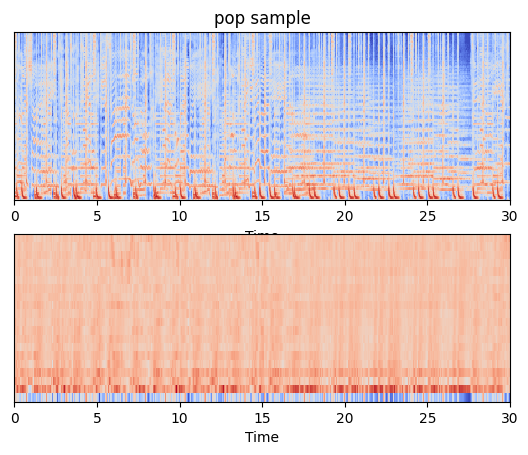

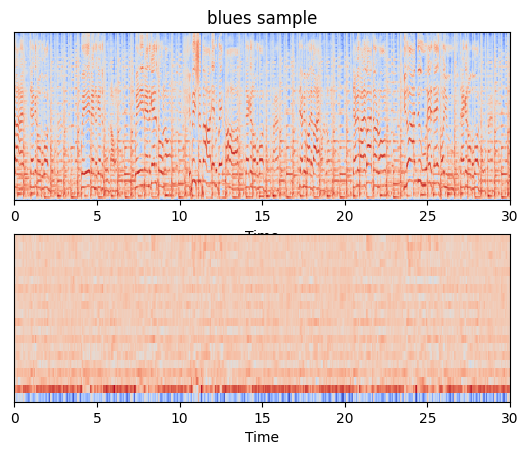

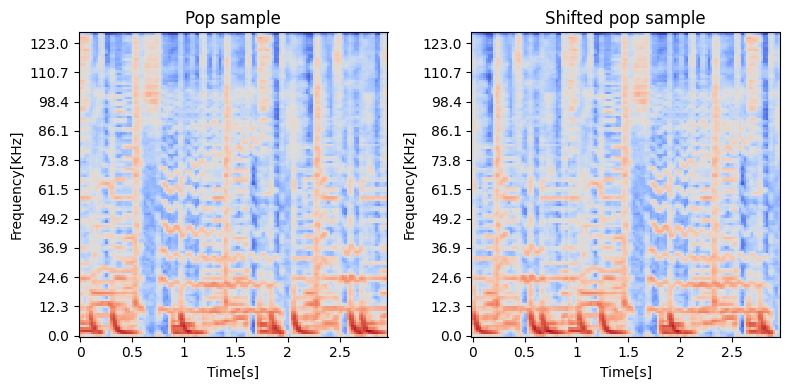

In [14]:
# test:
signal, mfcc = feature_extractor(genre_path_dict['pop'][0])
plt.subplot(2, 1, 1)
plt.title('pop sample')
display.specshow(signal, sr=sr, x_axis='time')
plt.subplot(2, 1, 2)
display.specshow(mfcc, sr=sr, x_axis='time')
plt.show()

signal, mfcc = feature_extractor(genre_path_dict['blues'][0])
plt.subplot(2, 1, 1)
plt.title('blues sample')
display.specshow(signal, sr=sr, x_axis='time')
plt.subplot(2, 1, 2)
display.specshow(mfcc, sr=sr, x_axis='time')
plt.show()

signal, chunk_num = frame_feature_extractor(genre_path_dict['pop'][0])
plt.figure(figsize=(8, 4))

# Original pop sample (left side)
plt.subplot(1, 2, 1)
plt.title('Pop sample')
display.specshow(np.flipud(np.rot90(signal[0], 1)), x_axis='time')
plt.xlabel('Time[s]')
plt.ylabel('Frequency[KHz]')
plt.yticks(np.arange(0, signal[0].shape[0], step=12.3))  # Adjust step as needed

# Shifted pop sample (right side)
plt.subplot(1, 2, 2)
plt.title('Shifted pop sample')
display.specshow(np.flipud(np.rot90(np.roll(signal[0], 40, axis=0), 1)), x_axis='time')
plt.xlabel('Time[s]')
plt.ylabel('Frequency[KHz]')
plt.yticks(np.arange(0, signal[0].shape[0], step=12.3))  # Adjust step as needed

plt.tight_layout()
plt.show()


## Build datasets

In [39]:
def build_tag(genre):
    target = np.zeros(len(label_dict), dtype=int)
    pos = label_dict.get(genre)
    target[pos] = 1
    return target

build_tag('pop').shape

(10,)

In [40]:
signal[0].shape, chunk_num

((128, 128), 7)

In [42]:
data_set_path = '../dataset/all_long.h5'
dataset = h5py.File(data_set_path, 'a')

In [43]:
total_chunks = total_file * chunk_num
mel_shape = signal[0].shape
total_chunks, mel_shape

(6993, (128, 128))

In [44]:
dataset.create_dataset('mel', shape=(total_chunks, mel_shape[0], mel_shape[1]), dtype=np.float32)
dataset.create_dataset('tag', shape=(total_chunks, 10 ), dtype=int)   

<HDF5 dataset "tag": shape (6993, 10), type "<i8">

### load data

In [45]:
count = 0
for key in label_dict:
    print('deal with {0}'.format(key))
    current_num = len(genre_path_dict.get(key))
    print(current_num, end='')
    for file_i, file in enumerate(genre_path_dict.get(key)):
        mel_list, _ = frame_feature_extractor(file)
        for mel_signal_chunk in mel_list:
            dataset['tag'][count] = build_tag(key)
            dataset['mel'][count] = mel_signal_chunk
            count += 1
        if file_i % 10 == 9:
            print('->{0}'.format(file_i), end='')
    print(' ')
dataset.close()
print(count)

deal with jazz
99->9->19->29->39->49->59->69->79->89 
deal with classical
100->9->19->29->39->49->59->69->79->89->99 
deal with hiphop
100->9->19->29->39->49->59->69->79->89->99 
deal with rock
100->9->19->29->39->49->59->69->79->89->99 
deal with metal
100->9->19->29->39->49->59->69->79->89->99 
deal with pop
100->9->19->29->39->49->59->69->79->89->99 
deal with reggae
100->9->19->29->39->49->59->69->79->89->99 
deal with disco
100->9->19->29->39->49->59->69->79->89->99 
deal with country
100->9->19->29->39->49->59->69->79->89->99 
deal with blues
100->9->19->29->39->49->59->69->79->89->99 
6993


## Build Separate Datasets

In [46]:
import random

In [47]:
data_set_path = '../dataset/all_long.h5'
dataset = h5py.File(data_set_path, 'r')

In [48]:
train_file = total_chunks * 0.8
valid_file = total_chunks * 0.1
test_file = total_chunks * 0.1

In [49]:
train_set = '../dataset/train_long.h5'
valid_set = '../dataset/valid_long.h5'
test_set = '../dataset/test_long.h5'

In [50]:
files = [int(a) for a in [train_file, valid_file, test_file]]
sets = [train_set, valid_set, test_set]
print(files)

[5594, 699, 699]


### Shuffle and create

In [52]:
idx = [i for i in range(total_chunks)]
random.seed(516)
random.shuffle(idx)

In [53]:
train_idx = idx[:files[0]]
valid_idx = idx[files[0]: files[0]+files[1]]
test_idx = idx[-files[2]:]
indices = [train_idx, valid_idx, test_idx]

### Copy

In [54]:
for i, dset in enumerate(sets):
    s_set = h5py.File(dset, 'a')
    indice = indices[i]
    file_num = files[i]
    
    s_set.create_dataset('mel', shape=(file_num, mel_shape[0], mel_shape[1]), dtype=np.float32)
#     s_set.create_dataset('mfcc', shape=(file_num, mfcc_shape[0], mfcc_shape[1]), dtype=np.float32)
    s_set.create_dataset('tag', shape=(file_num, 10 ), dtype=int)
    
    count = 0
    for i in indice:
        s_set['mel'][count] = dataset['mel'][i]
#         s_set['mfcc'][count] = dataset['mfcc'][i]
        s_set['tag'][count] = dataset['tag'][i]
        count += 1
        
        if count % 10 == 0:
            print('*', end="")
    
    s_set.close()
    print()  
    print('Create Separate Datasets {0}'.format(dset))
    

*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Create Separate Datasets ../dataset/train_long.h5
*********************************************************************
Create Separate Datasets ../dataset/valid_long.h5
*********************************************************************
Create Separate Datasets ../dataset/test_long.h5


## Test Here

In [55]:
t_set = h5py.File(train_set, 'r')

In [56]:
print(t_set['mel'].shape)
print(t_set['tag'][:5])

(5594, 128, 128)
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


: 